Paper link: http://snap.stanford.edu/class/cs224w-2017/projects/cs224w-11-final.pdf

In [146]:
import numpy as np
import geopandas as gpd
import networkx as nx

In [46]:
from shapely.geometry import shape

In [152]:
import geopandas as gpd
import json
import os

file_path = os.path.join('data', 'santiago_tazs.json')

with open(file_path) as f:
    geo_json = json.load(f)['features'][:100]
    for g in geo_json:
        g['geometry'] = shape(g['geometry'])
        for k, v in g['properties'].items():
            g[k] = v

# open file
df = gpd.GeoDataFrame(geo_json)

df.drop(['type', 'properties'], inplace=True, axis=1)

df.head()

,geometry,ID,Com,Comuna,Zona,MOVEMENT_ID,DISPLAY_NAME
0,"POLYGON ((-70.50243 -33.41327, -70.50160 -33.4...",318,13114,Las Condes,0,1,ID 318
1,"POLYGON ((-70.48181 -33.38163, -70.48239 -33.3...",311,13114,Las Condes,0,2,ID 311
2,"POLYGON ((-70.50838 -33.38215, -70.50831 -33.3...",301,13114,Las Condes,0,3,ID 301
3,"POLYGON ((-70.69606 -33.23737, -70.69540 -33.2...",734,13301,Colina,0,4,ID 734
4,"POLYGON ((-70.50891 -33.36313, -70.50852 -33.3...",330,13115,Lo Barnechea,0,5,ID 330


In [154]:
df['centroid'] = df.geometry.apply(lambda x: x.centroid)

In [155]:
from sklearn.metrics.pairwise import haversine_distances

In [156]:
adjacency_dict = dict()

for _, row in df.iterrows():
    row_id = row.MOVEMENT_ID
    row_centroid = row.centroid
    # Get 'not disjoint' locations
    neighbors = df[(~df.geometry.disjoint(row.geometry)) & (df.MOVEMENT_ID != row_id)]

    # Remove own ID of the place from the list
    #neighbors = [n for n in neighbors if row_id != n.MOVEMENT_ID]

    neighbor_ids = neighbors.MOVEMENT_ID.tolist()
    neighbor_centroids = neighbors.centroid.tolist()

    # Add adjacency dict entry
    adjacency_dict[row_id] = { n: {'weight': haversine_distances([[row_centroid.x, row_centroid.y],[c.x, c.y]])[0,1]}
                              for n, c in zip(neighbor_ids, neighbor_centroids) }

In [147]:
spatial_network = nx.from_dict_of_dicts(adjacency_dict)

In [160]:
spatial_network.nodes()

NodeView(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100'))

In [157]:
nx.is_directed(spatial_network)

False

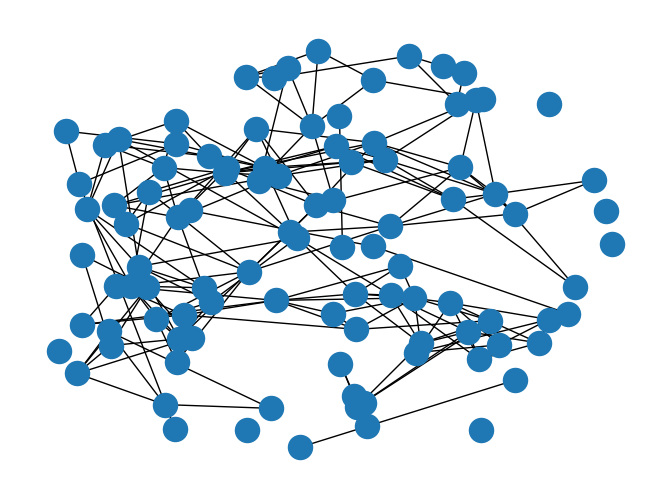

In [149]:
nx.draw(spatial_network)

In [150]:
import matplotlib.pyplot as plt

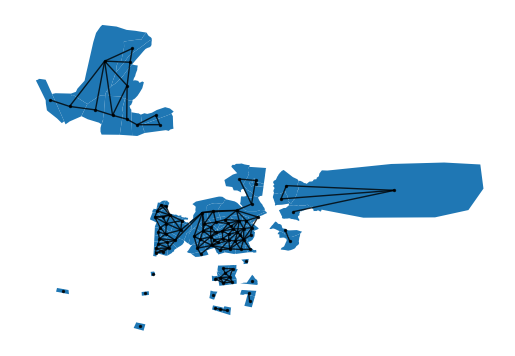

In [173]:
fig, ax = plt.subplots(1, 1)

df.plot(ax=ax)


coordinates = dict()
for i, r in df.iterrows():
    coordinates[r.MOVEMENT_ID] = (r.centroid.x, r.centroid.y)

nx.draw(
    spatial_network,
    coordinates,
    ax=ax,
    node_size=2,
    node_color="k",
    edge_color="k",
    alpha=0.8,
)
plt.show()